## How are snow depth and air temperature related? 
 In this notebook we will be considering the association between two variables and how that association may change through time. In particular we will be looking at the relation between snow depth and air temperature and how this varies by month. Scientifically, it makes sense that these two variables should be related to one another (probably negatively, since we would expect less snow on hot days). But would we expect there to be the same correlation throughout the year? A lot of factors change through the year that might alter this relationship. For example, what if some months received no snow? We might expect a weak correlation for those months! We will use some plotting functionality that allows us to group variables by time period to examine month-specific correlations between snow depth and air temperature.

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
#import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import colormaps as cmaps
from readCMIP5 import *

%pylab inline

matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['mod']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<div class="alert alert-warning">
<h3>First, read the datasets, find their means, combine them, and give them a date index.</h3>
</div>

In [3]:
snow_depth = readCMIP5("../data/SnowDepth_snd/", "gridded", "rcp45", "1", "snd")[2]

HELLO
../data/SnowDepth_snd/snd_grid50N_CCSM4_rcp45_1.nc


In [4]:
surface_temp = readCMIP5("../data/SeaSurfaceTemperature_tos/",'gridded','rcp45','1','tos')[2]

HELLO
../data/SeaSurfaceTemperature_tos/tos_grid50N_CCSM4_rcp45_1.nc


In [5]:
snow_depth_means = np.asarray(snow_depth.mean(axis=3).mean(axis=2))
snow_depth_means = snow_depth_means.reshape([95*12])

In [6]:
surface_temp_means = np.asarray(surface_temp.mean(axis=3).mean(axis=2))
surface_temp_means = surface_temp_means.reshape([95*12])

In [7]:
both_means = np.transpose(np.vstack((snow_depth_means, surface_temp_means)))

In [8]:
both_means_df = pd.DataFrame(both_means, columns=["snd", "tos"])

In [9]:
month_idx = pd.date_range('2005-01-01', periods=95*12, freq='1M')
both_means_df = both_means_df.set_index(month_idx)

<div class="alert alert-warning">
<h3>Seaborn, which has been imported here as "sns", is a plotting library for python that has higher-level funcationality than matplotlib. We'll use it to examine the relationship in question, beginning with the pairplot function.</h3>
</div>

/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


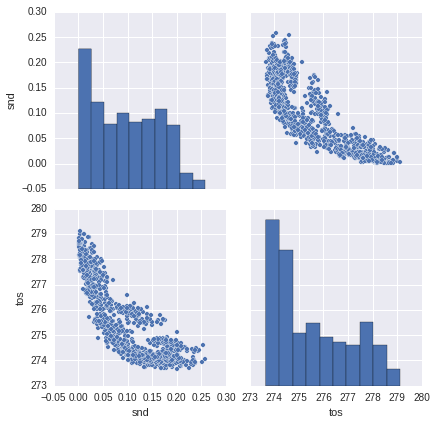

In [10]:
sns.pairplot(both_means_df)

<div class="alert alert-warning">
<h3>When exploring datasets, both plots and tables can be helpful. The correlation is a measure of how linearly related two variables are. It's not a perfect measure of relatedness but often it is a good place to start. Although the plots indicate that the relationship is not really linear, the correlation of -0.84 informs us that there is a strong negative relationship. This is not surprsigin since we might expect warmer temperatures to cause snow to melt, thus decreasing snow depth.</h3>
</div>

In [11]:
both_means_df.corr()

,snd,tos
snd,1.000000,-0.848155
tos,-0.848155,1.000000


<div class="alert alert-warning">
<h3>The pairplot function allows coloring the points according to the value of a variable. In this case, we created a new variable, for the month of the year, which was created by extracting the month from the date index.</h3>
</div>

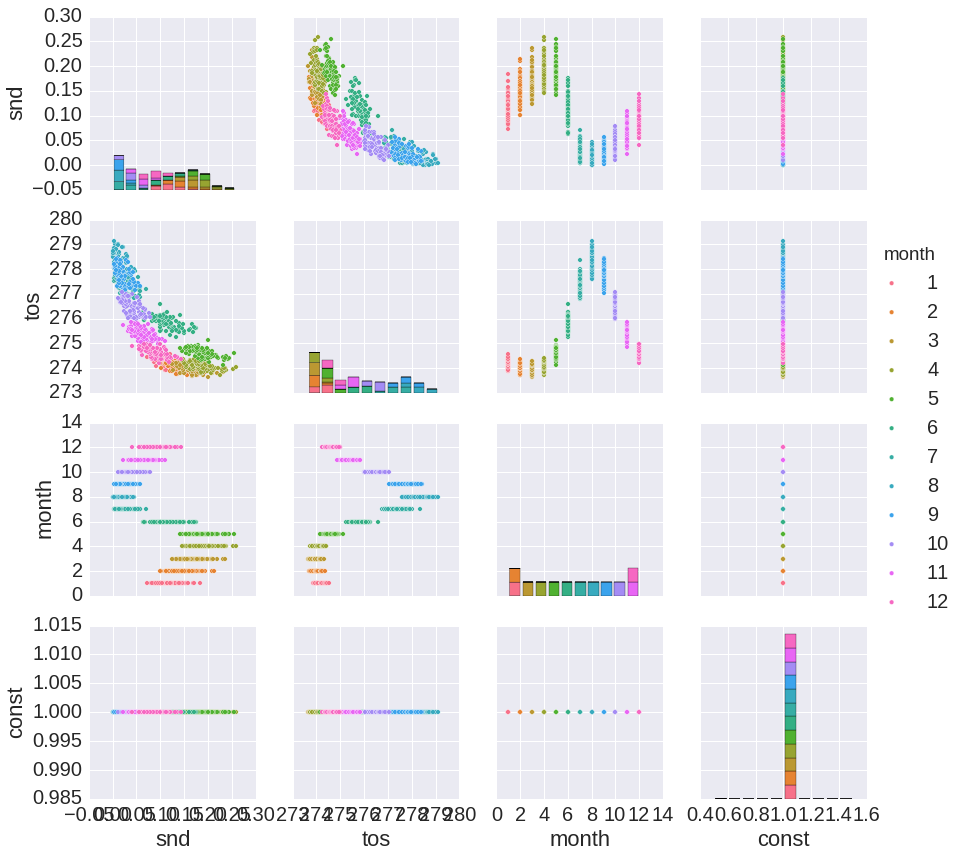

In [74]:
both_means_df["month"] = both_means_df.index.month
sns.pairplot(both_means_df, hue="month")

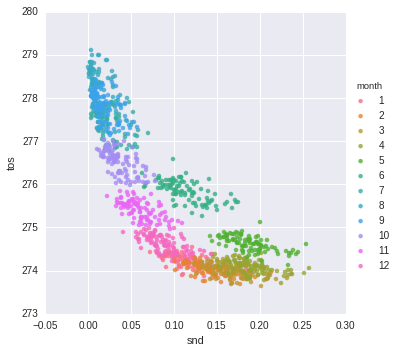

In [13]:
sns.lmplot(x="snd", y="tos", data=both_means_df, size=5, hue="month", fit_reg=False)

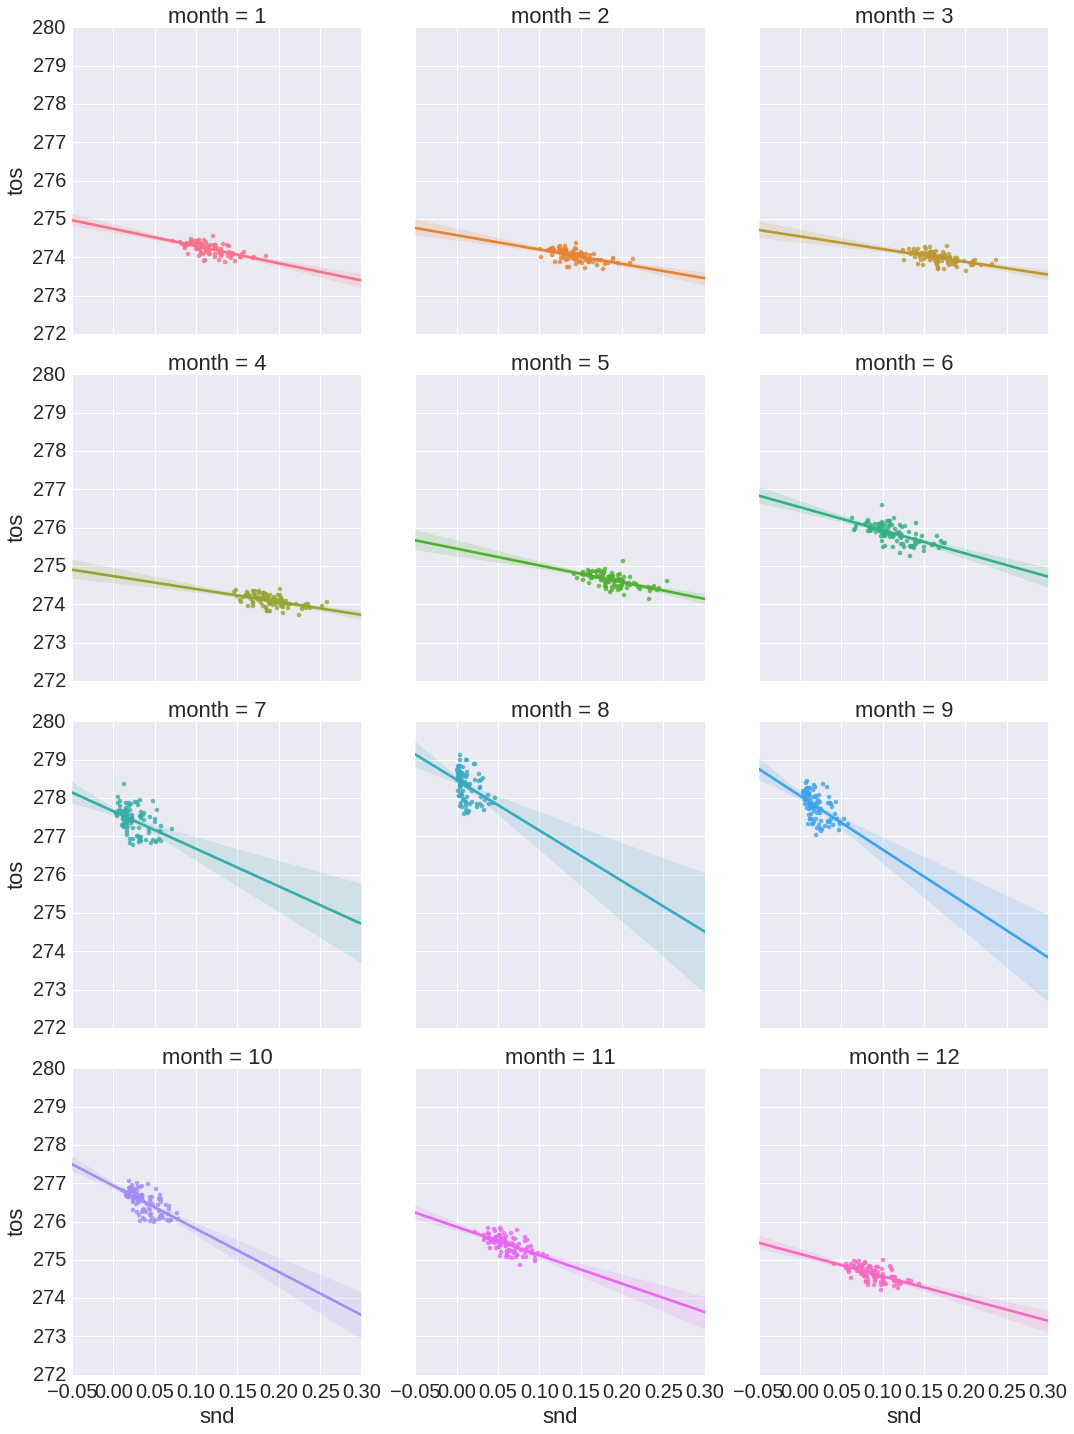

In [14]:
sns.set(font_scale=2)  #larger labels
sns.lmplot(x="snd", y="tos", data=both_means_df, size=5, col="month", hue="month", col_wrap=3)

<div class="alert alert-warning">
<h3>Another example of seaborn's advanced plotting is to show the contours of density estimates. These show where the highest concentration of points is. In particular it seems that there are two clear peaks in the concentration.</h3>
</div>

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)
/usr/lib/python2.7/dist-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


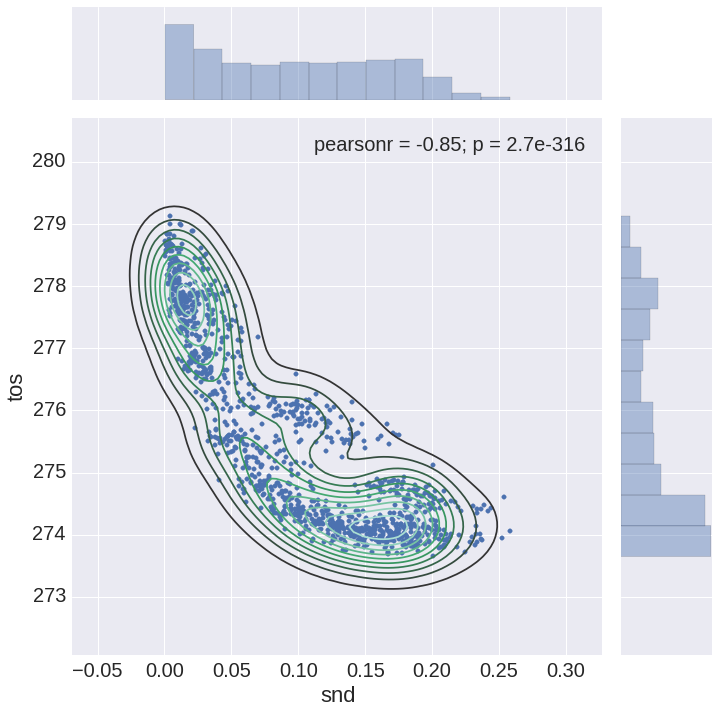

In [15]:
sns.jointplot(x="snd", y="tos", data=both_means_df, size=10).plot_joint(sns.kdeplot)

In [92]:
both_means_df = sm.add_constant(both_means_df, prepend=False)
both_means_df.head()
both_means_df["month"] = both_means_df.index.month

In [104]:
# Define simple model predicting snd given tos and month (treating month as a categorical variable)
mod = smf.ols(formula='snd ~ tos + C(month)', data=both_means_df)
res = mod.fit()
print res.resid.var()
print res.summary()

0.000297072945358
                            OLS Regression Results                            
Dep. Variable:                    snd   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     1289.
Date:                Tue, 16 Aug 2016   Prob (F-statistic):               0.00
Time:                        15:45:30   Log-Likelihood:                 3012.2
No. Observations:                1140   AIC:                            -5998.
Df Residuals:                    1127   BIC:                            -5933.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept         10.2868 

In [105]:
# Define model predicting snd given tos and month (treating month as a categorical variable)
# this one uses interaction terms, so effectively each month has a different slope.
# this is similar to what seaborn appears to do
mod = smf.ols(formula='snd ~ tos * C(month)', data=both_means_df)
res = mod.fit()
print res.resid.var()
print res.summary()

0.000256134699317
                            OLS Regression Results                            
Dep. Variable:                    snd   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     779.9
Date:                Tue, 16 Aug 2016   Prob (F-statistic):               0.00
Time:                        15:46:59   Log-Likelihood:                 3096.7
No. Observations:                1140   AIC:                            -6145.
Df Residuals:                    1116   BIC:                            -6024.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept         